In [1]:
import numpy as np
import pandas as pd
import joblib
import os
import random
import optuna
from tqdm import tqdm
random.seed(5)
np.random.seed(5)

# Визуализация
import matplotlib.pyplot as plt

# Модели
from sklearn.ensemble import RandomForestRegressor
from catboost import (Pool,
                      cv,
                      CatBoostRegressor)

# Метрики
from sklearn.metrics import (r2_score,
                             mean_squared_error as MSE,
                             mean_absolute_error as MAE)

# Создание пайплайна
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Масштабирование и кодирование признаков
from sklearn.preprocessing import TargetEncoder

# Отбор признаков
from sklearn.feature_selection import SequentialFeatureSelector

DATA_PATH = '../data'
MODEL_PATH = '../models/'

## Загрузка и подготовка данных

In [2]:
# Загрузим датасет.
# Зададим типы данных в колонках.
dtypes_of_data = {
            'car_make':'category',
            'car_model':'category',
            'car_gen':'category',
            'car_type':'category',
            'car_compl':'object',
            #'ann_date':datetime64[ns],
            'car_price':float,
            'ann_city':'category',
            'avail':'category',
            'year':int,
            'mileage':float,
            'color':'category',
            'eng_size':float,
            'eng_power':int,
            'eng_type':'category',
            'pow_resrv':int,
            'options':'object',
            'transmission':'category',
            'drive':'category',
            'st_wheel':'category',
            'count_owner':int,
            'original_pts':'category',
            'state_mark':'category',
            'class_auto':'category',
            'door_count':int,
            'long':int,
            'width':int,
            'height':int,
            'clearence':int,
            'v_tank':int,
            'curb_weight':int,
            'front_brakes':'category',
            'rear_brakes':'category',
            'max_speed':int,
            'acceleration':float,
            'fuel_cons':float,
            'fuel_brand':'category',
            'engine_loc1':'category',
            'engine_loc2':'category',
            'turbocharg':'category',
            'max_torq':int,
            'cyl_count':int,
            'seat_count':int,
            'v_bag':int,
            'acc_capacity':int,
            'age':int,
            'age_mod':float,
            'mileage_mod': float,
            'acceleration_mod': float,
            'cyl_count_mod': float            
        }
try:
    train = pd.read_csv(os.path.join(DATA_PATH, 'processed_train.csv'),
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
    test = pd.read_csv(os.path.join(DATA_PATH, 'processed_test.csv'),
               dtype=dtypes_of_data, parse_dates=['ann_date'])
except:
    print('Changed directory for model to current directory')
    train = pd.read_csv('processed_train.csv',
                   dtype=dtypes_of_data, parse_dates=['ann_date'])
    test = pd.read_csv('processed_test.csv',
               dtype=dtypes_of_data, parse_dates=['ann_date'])
print(f'train {train.shape}, test {test.shape}')

train (122898, 50), test (40966, 50)


In [3]:
# Уменьшим избыточную разрядность чисел
fcols = train.select_dtypes('floating').columns
icols = train.select_dtypes('integer').columns
train[fcols] = train[fcols].apply(pd.to_numeric, downcast='float')
train[icols] = train[icols].apply(pd.to_numeric, downcast='integer')
test[fcols] = test[fcols].apply(pd.to_numeric, downcast='float')
test[icols] = test[icols].apply(pd.to_numeric, downcast='integer')

In [4]:
# Рассмотрим общие сведения
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122898 entries, 0 to 122897
Data columns (total 50 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   car_make          122898 non-null  category      
 1   car_model         122898 non-null  category      
 2   car_gen           122898 non-null  category      
 3   car_type          122898 non-null  category      
 4   car_compl         122898 non-null  object        
 5   car_price         122898 non-null  float32       
 6   ann_city          122898 non-null  category      
 7   avail             122898 non-null  category      
 8   year              122898 non-null  int16         
 9   mileage           122898 non-null  float32       
 10  color             122898 non-null  category      
 11  eng_size          122898 non-null  float32       
 12  eng_power         122898 non-null  int16         
 13  eng_type          122898 non-null  category      
 14  pow_

In [5]:
# Рассмотрим общие сведения
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40966 entries, 0 to 40965
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   car_make          40966 non-null  category      
 1   car_model         40966 non-null  category      
 2   car_gen           40966 non-null  category      
 3   car_type          40966 non-null  category      
 4   car_compl         40966 non-null  object        
 5   car_price         40966 non-null  float32       
 6   ann_city          40966 non-null  category      
 7   avail             40966 non-null  category      
 8   year              40966 non-null  int16         
 9   mileage           40966 non-null  float32       
 10  color             40966 non-null  category      
 11  eng_size          40966 non-null  float32       
 12  eng_power         40966 non-null  int16         
 13  eng_type          40966 non-null  category      
 14  pow_resrv         4096

## Метрики качества

Для информации о качестве моделей будем рассчитывать R2, MSE, MAE.

Возьмём в качестве дополнительной метрики долю верно спрогнозированных цен, при этом ошибка недопрогноза и перепрогноза будет учитываться по-разному:
- по недопрогнозов учитываем те прогнозы, которые в пределах отклонения under_est,
- по перепрогнозам - те прогнозы, которые в пределах отклонения over_est.  
Т.е. среди всех предсказанных цен на авто посчитаем долю прогнозов, отличающихся от реальных цен на эти авто не более чем на `under_est`% в сторону уменьшения и не более чем на `over_est`% в сторону увеличения.

In [6]:
def good_prediction_part(y_true, y_pred, under_est=0.05, over_est=0.10):
    deviations = y_pred / y_true

    result = (((deviations - 1 <= over_est) & (deviations > 1)).sum() +
              ((1 - deviations <= under_est) & (deviations < 1)).sum()) / len(y_true)

    return result

In [7]:
def print_metrics(model, y_train, y_test, X_train, X_test, log_y=False):
    test_pred = model.predict(X_test)
    train_pred = model.predict(X_train)
    if log_y:
        test_pred = np.exp(test_pred)
        train_pred = np.exp(train_pred)
        
    print('Обучающая выборка')
    print(f'{"R2": <40} {r2_score(y_train, train_pred): .5}')
    print(f'{"MSE": <40} {MSE(y_train, train_pred): .5}')
    print(f'{"MAE": <40} {MAE(y_train, train_pred): .5}')
    print(f'{"Доля предсказаний 0,95-1,1 от цены": <40} {good_prediction_part(y_train, train_pred): .5}')
    print('Тестовая выборка')
    print(f'{"R2": <40} {r2_score(y_test, test_pred): .5}')
    print(f'{"MSE": <40} {MSE(y_test, test_pred): .5}')
    print(f'{"MAE": <40} {MAE(y_test, test_pred): .5}')
    print(f'{"Доля предсказаний 0,95-1,1 от цены": <40} {good_prediction_part(y_test, test_pred): .5}')

## Эксперименты с моделями

In [8]:
# Список признаков
X = ['car_make', 'car_model', 'car_gen', 'car_type', 'car_compl',
       'ann_city', 'avail', 'year', 'mileage', 'color',
       'eng_size', 'eng_power', 'eng_type', 'pow_resrv', 'options',
       'transmission', 'drive', 'st_wheel', 'count_owner', 'original_pts',
       'state_mark', 'class_auto', 'door_count', 'long', 'width', 'height',
       'v_tank', 'curb_weight', 'front_brakes', 'rear_brakes', 'max_speed',
       'acceleration', 'fuel_cons', 'fuel_brand', 'engine_loc1', 'engine_loc2',
       'turbocharg', 'max_torq', 'cyl_count', 'seat_count', 'clearence',
       'v_bag', 'acc_capacity', 'age', 'age_mod', 'mileage_mod',
       'acceleration_mod', 'cyl_count_mod']

# Целевая переменная
y = 'car_price'

In [9]:
# Составим список числовых признаков
num_features = (
    train[X].select_dtypes(
    exclude=['object', 'category']
    ).columns.to_list()
)
num_features

['year',
 'mileage',
 'eng_size',
 'eng_power',
 'pow_resrv',
 'count_owner',
 'door_count',
 'long',
 'width',
 'height',
 'v_tank',
 'curb_weight',
 'max_speed',
 'acceleration',
 'fuel_cons',
 'max_torq',
 'cyl_count',
 'seat_count',
 'clearence',
 'v_bag',
 'acc_capacity',
 'age',
 'age_mod',
 'mileage_mod',
 'acceleration_mod',
 'cyl_count_mod']

In [10]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include=['category']).columns.to_list()
cat_features

['car_make',
 'car_model',
 'car_gen',
 'car_type',
 'ann_city',
 'avail',
 'color',
 'eng_type',
 'transmission',
 'drive',
 'st_wheel',
 'original_pts',
 'state_mark',
 'class_auto',
 'front_brakes',
 'rear_brakes',
 'fuel_brand',
 'engine_loc1',
 'engine_loc2',
 'turbocharg']

In [11]:
y_train = train[y].copy()
X_train = train[cat_features + num_features].copy()
y_test = test[y].copy()
X_test = test[cat_features + num_features].copy()

In [12]:
# Проверим размерность
X_train.shape, y_train.shape

((122898, 46), (122898,))

In [13]:
# Проверим размерность
X_test.shape, y_test.shape

((40966, 46), (40966,))

### Случайный лес

In [ ]:
# Функция для подбора гиперпараметров
def objective_rf(trial):
    # Задаем диапазоны для гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 6, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 1000)
    max_features = trial.suggest_float('max_features', 0.3, 1.0)
    smooth = trial.suggest_float('smooth', 10, 1000)
    
    # Определим набор преобразований столбцов
    col_transformer = make_column_transformer(
        (
            TargetEncoder(smooth=smooth),
            cat_features
        ),
    
        remainder='passthrough',
        verbose_feature_names_out=True
    )

    # Создаем модель с текущими гиперпараметрами
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1
    )

    # Создаем пайплайн
    pipe = make_pipeline(col_transformer, model)

    # Вычисляем кросс-валидацию с кастомной метрикой
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    # Возвращаем среднее значение метрики
    return scores.mean()

# Запускаем подбор гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=500, n_jobs=-1, gc_after_trial=True, show_progress_bar=True)

# Выводим лучшие параметры
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

Best trial: 288. Best value: 0.733747:  79%|███████▉  | 394/500 [2:38:10<51:24, 29.10s/it]

[I 2025-03-11 22:34:10,819] Trial 394 finished with value: 0.6647036722715942 and parameters: {'n_estimators': 265, 'max_depth': 15, 'min_samples_leaf': 31, 'max_features': 0.6205323157927395, 'smooth': 241.31327384751023}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  79%|███████▉  | 395/500 [2:38:37<1:42:38, 58.65s/it]

[I 2025-03-11 22:34:37,297] Trial 398 finished with value: 0.42334473503899767 and parameters: {'n_estimators': 263, 'max_depth': 15, 'min_samples_leaf': 970, 'max_features': 0.5164599562390285, 'smooth': 231.05872186864306}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  79%|███████▉  | 396/500 [2:39:10<1:24:24, 48.70s/it]

[I 2025-03-11 22:35:09,960] Trial 395 finished with value: 0.664278113388497 and parameters: {'n_estimators': 259, 'max_depth': 15, 'min_samples_leaf': 31, 'max_features': 0.6308437964842686, 'smooth': 236.01934438729765}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  79%|███████▉  | 397/500 [2:40:31<1:15:01, 43.70s/it]

[I 2025-03-11 22:36:31,028] Trial 396 finished with value: 0.6655352306622704 and parameters: {'n_estimators': 264, 'max_depth': 30, 'min_samples_leaf': 30, 'max_features': 0.6282580250501653, 'smooth': 245.6836125468037}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  80%|███████▉  | 398/500 [2:40:59<1:33:20, 54.91s/it]

[I 2025-03-11 22:36:55,069] Trial 397 finished with value: 0.6656078771802069 and parameters: {'n_estimators': 260, 'max_depth': 17, 'min_samples_leaf': 31, 'max_features': 0.6322659906664907, 'smooth': 234.47605454441623}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  80%|███████▉  | 399/500 [2:41:40<1:17:01, 45.76s/it]

[I 2025-03-11 22:37:40,558] Trial 399 finished with value: 0.666812057059245 and parameters: {'n_estimators': 258, 'max_depth': 27, 'min_samples_leaf': 30, 'max_features': 0.6335139633151546, 'smooth': 240.44998806204268}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  80%|████████  | 400/500 [2:42:32<1:16:39, 46.00s/it]

[I 2025-03-11 22:38:32,246] Trial 401 finished with value: 0.5240039176840539 and parameters: {'n_estimators': 260, 'max_depth': 17, 'min_samples_leaf': 307, 'max_features': 0.6361408885316754, 'smooth': 230.68904437286}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  80%|████████  | 401/500 [2:43:28<1:18:13, 47.41s/it]

[I 2025-03-11 22:39:28,634] Trial 400 finished with value: 0.6672651061345682 and parameters: {'n_estimators': 266, 'max_depth': 17, 'min_samples_leaf': 32, 'max_features': 0.6362715483992218, 'smooth': 236.1868363728515}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  80%|████████  | 402/500 [2:44:08<1:21:33, 49.94s/it]

[I 2025-03-11 22:40:05,025] Trial 402 finished with value: 0.6673674383288114 and parameters: {'n_estimators': 278, 'max_depth': 13, 'min_samples_leaf': 30, 'max_features': 0.6365439323501814, 'smooth': 229.82862937366562}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  81%|████████  | 403/500 [2:45:28<1:14:00, 45.78s/it]

[I 2025-03-11 22:41:28,355] Trial 403 finished with value: 0.6611788206913279 and parameters: {'n_estimators': 264, 'max_depth': 13, 'min_samples_leaf': 31, 'max_features': 0.6432617600289895, 'smooth': 299.8028958227621}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  81%|████████  | 404/500 [2:46:37<1:31:40, 57.30s/it]

[I 2025-03-11 22:42:32,518] Trial 404 finished with value: 0.6614336691249927 and parameters: {'n_estimators': 262, 'max_depth': 18, 'min_samples_leaf': 32, 'max_features': 0.6462151902859855, 'smooth': 235.48005781658946}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  81%|████████  | 405/500 [2:46:58<1:34:21, 59.60s/it]

[I 2025-03-11 22:42:58,385] Trial 405 finished with value: 0.663277798651114 and parameters: {'n_estimators': 263, 'max_depth': 13, 'min_samples_leaf': 30, 'max_features': 0.6396509435626432, 'smooth': 768.01612856749}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  81%|████████  | 406/500 [2:47:55<1:16:33, 48.86s/it]

[I 2025-03-11 22:43:55,549] Trial 406 finished with value: 0.6640574524310621 and parameters: {'n_estimators': 258, 'max_depth': 15, 'min_samples_leaf': 29, 'max_features': 0.6471123604803541, 'smooth': 177.83998691788173}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  81%|████████▏ | 407/500 [2:48:53<1:20:53, 52.18s/it]

[I 2025-03-11 22:44:53,072] Trial 407 finished with value: 0.667352024720518 and parameters: {'n_estimators': 229, 'max_depth': 17, 'min_samples_leaf': 30, 'max_features': 0.6982371698357003, 'smooth': 239.82012592737027}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  82%|████████▏ | 408/500 [2:50:39<1:22:36, 53.87s/it]

[I 2025-03-11 22:46:39,482] Trial 408 finished with value: 0.6662756050907902 and parameters: {'n_estimators': 284, 'max_depth': 17, 'min_samples_leaf': 29, 'max_features': 0.7043221028400324, 'smooth': 238.2974029305076}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  82%|████████▏ | 409/500 [2:51:35<1:44:51, 69.14s/it]

[I 2025-03-11 22:47:35,453] Trial 409 finished with value: 0.6677169871763036 and parameters: {'n_estimators': 280, 'max_depth': 27, 'min_samples_leaf': 27, 'max_features': 0.708574063119475, 'smooth': 238.19139475542102}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  82%|████████▏ | 410/500 [2:51:47<1:37:03, 64.71s/it]

[I 2025-03-11 22:47:47,921] Trial 412 finished with value: 0.6575969927952666 and parameters: {'n_estimators': 263, 'max_depth': 13, 'min_samples_leaf': 31, 'max_features': 0.5120474264445756, 'smooth': 240.14825131245985}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  82%|████████▏ | 411/500 [2:52:18<1:13:07, 49.30s/it]

[I 2025-03-11 22:48:18,255] Trial 410 finished with value: 0.6650896026440616 and parameters: {'n_estimators': 266, 'max_depth': 17, 'min_samples_leaf': 30, 'max_features': 0.7090602225064174, 'smooth': 243.40389110070524}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  82%|████████▏ | 412/500 [2:52:26<1:03:45, 43.48s/it]

[I 2025-03-11 22:48:22,147] Trial 411 finished with value: 0.669149832274109 and parameters: {'n_estimators': 266, 'max_depth': 15, 'min_samples_leaf': 28, 'max_features': 0.6486964419243322, 'smooth': 236.09894275397767}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  83%|████████▎ | 413/500 [2:53:56<46:12, 31.87s/it]  

[I 2025-03-11 22:49:56,112] Trial 413 finished with value: 0.6660238099852425 and parameters: {'n_estimators': 280, 'max_depth': 13, 'min_samples_leaf': 29, 'max_features': 0.6467816089359005, 'smooth': 115.07449522553482}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  83%|████████▎ | 414/500 [2:54:58<1:13:43, 51.44s/it]

[I 2025-03-11 22:50:53,224] Trial 415 finished with value: 0.6670172510743388 and parameters: {'n_estimators': 231, 'max_depth': 13, 'min_samples_leaf': 29, 'max_features': 0.5130627364307354, 'smooth': 180.2884483770595}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  83%|████████▎ | 415/500 [2:56:23<1:14:19, 52.46s/it]

[I 2025-03-11 22:52:16,137] Trial 414 finished with value: 0.667726873202565 and parameters: {'n_estimators': 268, 'max_depth': 27, 'min_samples_leaf': 30, 'max_features': 0.6534912903920985, 'smooth': 247.19644214089183}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  83%|████████▎ | 416/500 [2:57:01<1:27:04, 62.20s/it]

[I 2025-03-11 22:53:00,995] Trial 416 finished with value: 0.6655464014214965 and parameters: {'n_estimators': 279, 'max_depth': 13, 'min_samples_leaf': 29, 'max_features': 0.649951936514163, 'smooth': 236.25024941434543}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  83%|████████▎ | 417/500 [2:57:16<1:16:51, 55.56s/it]

[I 2025-03-11 22:53:13,820] Trial 418 finished with value: 0.6672211773670003 and parameters: {'n_estimators': 230, 'max_depth': 15, 'min_samples_leaf': 28, 'max_features': 0.6503533296836841, 'smooth': 254.70487568308695}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  84%|████████▎ | 418/500 [2:57:27<58:23, 42.72s/it]  

[I 2025-03-11 22:53:27,492] Trial 420 finished with value: 0.6130629183624499 and parameters: {'n_estimators': 280, 'max_depth': 13, 'min_samples_leaf': 81, 'max_features': 0.305993999134441, 'smooth': 252.8214254089944}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  84%|████████▍ | 419/500 [2:58:17<46:06, 34.16s/it]

[I 2025-03-11 22:54:17,113] Trial 419 finished with value: 0.6203986123615339 and parameters: {'n_estimators': 228, 'max_depth': 15, 'min_samples_leaf': 79, 'max_features': 0.6550915556386687, 'smooth': 120.22147924705696}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  84%|████████▍ | 420/500 [2:58:44<52:22, 39.28s/it]

[I 2025-03-11 22:54:40,781] Trial 417 finished with value: 0.6502200291285302 and parameters: {'n_estimators': 230, 'max_depth': 15, 'min_samples_leaf': 28, 'max_features': 0.9078159719185608, 'smooth': 116.41072758785684}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  84%|████████▍ | 421/500 [3:00:18<45:16, 34.38s/it]

[I 2025-03-11 22:56:18,009] Trial 426 finished with value: 0.4969554398759638 and parameters: {'n_estimators': 80, 'max_depth': 17, 'min_samples_leaf': 422, 'max_features': 0.6497228175128149, 'smooth': 125.43415351973657}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  84%|████████▍ | 422/500 [3:00:37<1:08:58, 53.06s/it]

[I 2025-03-11 22:56:37,569] Trial 421 finished with value: 0.6681199774610341 and parameters: {'n_estimators': 232, 'max_depth': 13, 'min_samples_leaf': 27, 'max_features': 0.650924046082897, 'smooth': 247.1445818110302}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  85%|████████▍ | 423/500 [3:01:06<56:06, 43.73s/it]  

[I 2025-03-11 22:57:06,157] Trial 422 finished with value: 0.4946370460828726 and parameters: {'n_estimators': 277, 'max_depth': 13, 'min_samples_leaf': 408, 'max_features': 0.7038755874443934, 'smooth': 253.30090837422733}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  85%|████████▍ | 424/500 [3:03:07<49:37, 39.18s/it]

[I 2025-03-11 22:59:07,314] Trial 424 finished with value: 0.6582169744129042 and parameters: {'n_estimators': 282, 'max_depth': 15, 'min_samples_leaf': 30, 'max_features': 0.6526586133212621, 'smooth': 392.30251986419415}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  85%|████████▌ | 425/500 [3:03:28<1:18:57, 63.17s/it]

[I 2025-03-11 22:59:24,411] Trial 423 finished with value: 0.6666089011224384 and parameters: {'n_estimators': 282, 'max_depth': 18, 'min_samples_leaf': 28, 'max_features': 0.7035648813388774, 'smooth': 178.14411390301592}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  85%|████████▌ | 426/500 [3:03:52<1:01:07, 49.56s/it]

[I 2025-03-11 22:59:47,660] Trial 425 finished with value: 0.664584079878521 and parameters: {'n_estimators': 276, 'max_depth': 18, 'min_samples_leaf': 27, 'max_features': 0.6511772435233459, 'smooth': 385.5351382753175}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  85%|████████▌ | 427/500 [3:05:02<50:52, 41.81s/it]  

[I 2025-03-11 23:01:02,376] Trial 431 finished with value: 0.606631398292041 and parameters: {'n_estimators': 133, 'max_depth': 18, 'min_samples_leaf': 84, 'max_features': 0.3023948249565559, 'smooth': 381.2891234514827}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  86%|████████▌ | 428/500 [3:05:14<1:01:55, 51.61s/it]

[I 2025-03-11 23:01:14,058] Trial 428 finished with value: 0.6018017845268545 and parameters: {'n_estimators': 284, 'max_depth': 13, 'min_samples_leaf': 85, 'max_features': 0.6500345623232772, 'smooth': 409.32583437960466}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  86%|████████▌ | 429/500 [3:05:29<46:08, 38.99s/it]  

[I 2025-03-11 23:01:25,485] Trial 427 finished with value: 0.6659949913973449 and parameters: {'n_estimators': 286, 'max_depth': 17, 'min_samples_leaf': 26, 'max_features': 0.6519196453222451, 'smooth': 408.17939110019057}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  86%|████████▌ | 430/500 [3:06:11<36:22, 31.18s/it]

[I 2025-03-11 23:02:11,561] Trial 429 finished with value: 0.6588196842948707 and parameters: {'n_estimators': 230, 'max_depth': 18, 'min_samples_leaf': 27, 'max_features': 0.6557681376098216, 'smooth': 118.46054600581708}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  86%|████████▌ | 431/500 [3:06:30<41:11, 35.82s/it]

[I 2025-03-11 23:02:30,083] Trial 435 finished with value: 0.6001266035392419 and parameters: {'n_estimators': 17, 'max_depth': 18, 'min_samples_leaf': 76, 'max_features': 0.9049002357957061, 'smooth': 394.31950980157876}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  86%|████████▋ | 432/500 [3:06:54<34:08, 30.13s/it]

[I 2025-03-11 23:02:54,080] Trial 436 finished with value: 0.669685772052673 and parameters: {'n_estimators': 17, 'max_depth': 20, 'min_samples_leaf': 22, 'max_features': 0.7068889136339424, 'smooth': 732.4296362684155}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  87%|████████▋ | 433/500 [3:07:40<31:57, 28.62s/it]

[I 2025-03-11 23:03:37,529] Trial 437 finished with value: 0.7139434921737727 and parameters: {'n_estimators': 18, 'max_depth': 20, 'min_samples_leaf': 10, 'max_features': 0.7076933662977264, 'smooth': 381.53886595862986}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  87%|████████▋ | 434/500 [3:08:03<36:01, 32.75s/it]

[I 2025-03-11 23:04:02,953] Trial 432 finished with value: 0.6613400557423974 and parameters: {'n_estimators': 231, 'max_depth': 13, 'min_samples_leaf': 32, 'max_features': 0.7049788632044248, 'smooth': 838.2895062508553}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  87%|████████▋ | 435/500 [3:08:19<33:16, 30.72s/it]

[I 2025-03-11 23:04:19,436] Trial 434 finished with value: 0.4911043839715634 and parameters: {'n_estimators': 233, 'max_depth': 18, 'min_samples_leaf': 420, 'max_features': 0.7046797204543146, 'smooth': 181.22099703912042}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  87%|████████▋ | 436/500 [3:08:24<27:34, 25.86s/it]

[I 2025-03-11 23:04:24,176] Trial 430 finished with value: 0.6668289847398775 and parameters: {'n_estimators': 279, 'max_depth': 20, 'min_samples_leaf': 26, 'max_features': 0.6558547571861172, 'smooth': 875.2697717876003}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  87%|████████▋ | 437/500 [3:08:34<20:42, 19.73s/it]

[I 2025-03-11 23:04:34,864] Trial 440 finished with value: 0.6150264752276431 and parameters: {'n_estimators': 18, 'max_depth': 18, 'min_samples_leaf': 78, 'max_features': 0.5978181783243701, 'smooth': 412.8988350614282}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  88%|████████▊ | 438/500 [3:08:47<17:52, 17.29s/it]

[I 2025-03-11 23:04:47,818] Trial 438 finished with value: 0.6211596540267847 and parameters: {'n_estimators': 230, 'max_depth': 18, 'min_samples_leaf': 74, 'max_features': 0.31039450917618944, 'smooth': 412.0650713854431}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  88%|████████▊ | 438/500 [3:08:53<17:52, 17.29s/it]

[I 2025-03-11 23:04:50,286] Trial 433 finished with value: 0.6046152605931523 and parameters: {'n_estimators': 233, 'max_depth': 20, 'min_samples_leaf': 83, 'max_features': 0.7036991663313967, 'smooth': 382.0709167091906}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  88%|████████▊ | 440/500 [3:09:04<16:45, 16.75s/it]

[I 2025-03-11 23:05:04,213] Trial 442 finished with value: 0.6111847144223893 and parameters: {'n_estimators': 19, 'max_depth': 20, 'min_samples_leaf': 77, 'max_features': 0.727822345547153, 'smooth': 403.9338764208692}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  88%|████████▊ | 441/500 [3:09:06<11:46, 11.97s/it]

[I 2025-03-11 23:05:06,493] Trial 443 finished with value: 0.6155327259268705 and parameters: {'n_estimators': 19, 'max_depth': 18, 'min_samples_leaf': 75, 'max_features': 0.7253486655794901, 'smooth': 875.4507508446472}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  88%|████████▊ | 441/500 [3:09:08<11:46, 11.97s/it]

[I 2025-03-11 23:05:08,200] Trial 444 finished with value: 0.5930248473234182 and parameters: {'n_estimators': 17, 'max_depth': 18, 'min_samples_leaf': 84, 'max_features': 0.30887599924139947, 'smooth': 378.5124793316967}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  89%|████████▊ | 443/500 [3:09:35<06:57,  7.32s/it]

[I 2025-03-11 23:05:35,396] Trial 446 finished with value: 0.6181934219771482 and parameters: {'n_estimators': 18, 'max_depth': 18, 'min_samples_leaf': 77, 'max_features': 0.42120455029278697, 'smooth': 387.42449453743274}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  89%|████████▉ | 444/500 [3:09:43<12:01, 12.88s/it]

[I 2025-03-11 23:05:43,387] Trial 445 finished with value: 0.730214162839057 and parameters: {'n_estimators': 17, 'max_depth': 18, 'min_samples_leaf': 10, 'max_features': 0.72668086333081, 'smooth': 379.8302527452584}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  89%|████████▉ | 445/500 [3:09:52<10:45, 11.73s/it]

[I 2025-03-11 23:05:52,532] Trial 447 finished with value: 0.5982607481502018 and parameters: {'n_estimators': 19, 'max_depth': 18, 'min_samples_leaf': 82, 'max_features': 0.9302312022370033, 'smooth': 332.15926900116193}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  89%|████████▉ | 446/500 [3:10:05<09:42, 10.79s/it]

[I 2025-03-11 23:06:05,848] Trial 439 finished with value: 0.6052341527313851 and parameters: {'n_estimators': 233, 'max_depth': 18, 'min_samples_leaf': 85, 'max_features': 0.5985298513630928, 'smooth': 411.87870128135444}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  89%|████████▉ | 447/500 [3:10:22<10:06, 11.44s/it]

[I 2025-03-11 23:06:22,723] Trial 449 finished with value: 0.5992972433700807 and parameters: {'n_estimators': 18, 'max_depth': 20, 'min_samples_leaf': 78, 'max_features': 0.9068980609156932, 'smooth': 406.3397752761954}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  90%|████████▉ | 448/500 [3:10:30<11:29, 13.27s/it]

[I 2025-03-11 23:06:27,585] Trial 450 finished with value: 0.5982718239138045 and parameters: {'n_estimators': 17, 'max_depth': 18, 'min_samples_leaf': 81, 'max_features': 0.9374453793569896, 'smooth': 374.4953464554289}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  90%|████████▉ | 449/500 [3:10:46<09:10, 10.79s/it]

[I 2025-03-11 23:06:46,615] Trial 452 finished with value: 0.6991155400255834 and parameters: {'n_estimators': 16, 'max_depth': 18, 'min_samples_leaf': 14, 'max_features': 0.6004790114255465, 'smooth': 386.7892247323737}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  90%|█████████ | 450/500 [3:10:50<11:12, 13.46s/it]

[I 2025-03-11 23:06:50,609] Trial 441 finished with value: 0.6030051337140026 and parameters: {'n_estimators': 231, 'max_depth': 18, 'min_samples_leaf': 86, 'max_features': 0.6026539610668804, 'smooth': 381.88232979785323}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  90%|█████████ | 451/500 [3:11:25<08:46, 10.74s/it]

[I 2025-03-11 23:07:25,695] Trial 454 finished with value: 0.6814170163832916 and parameters: {'n_estimators': 18, 'max_depth': 25, 'min_samples_leaf': 17, 'max_features': 0.7334820976430431, 'smooth': 330.1239502947117}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  90%|█████████ | 452/500 [3:11:35<14:07, 17.65s/it]

[I 2025-03-11 23:07:35,690] Trial 456 finished with value: 0.7066455345439386 and parameters: {'n_estimators': 18, 'max_depth': 18, 'min_samples_leaf': 13, 'max_features': 0.44312190990441064, 'smooth': 407.3901874450439}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  91%|█████████ | 453/500 [3:11:44<11:45, 15.02s/it]

[I 2025-03-11 23:07:43,981] Trial 453 finished with value: 0.6920672264929599 and parameters: {'n_estimators': 134, 'max_depth': 6, 'min_samples_leaf': 12, 'max_features': 0.5969897321145345, 'smooth': 394.8880266161019}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  91%|█████████ | 454/500 [3:11:49<09:56, 12.96s/it]

[I 2025-03-11 23:07:49,088] Trial 457 finished with value: 0.7017337010507092 and parameters: {'n_estimators': 18, 'max_depth': 6, 'min_samples_leaf': 10, 'max_features': 0.7264677665395137, 'smooth': 406.33069764632177}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  91%|█████████ | 455/500 [3:11:50<07:55, 10.58s/it]

[I 2025-03-11 23:07:50,670] Trial 448 finished with value: 0.6072107767570057 and parameters: {'n_estimators': 137, 'max_depth': 18, 'min_samples_leaf': 75, 'max_features': 0.9064073762958169, 'smooth': 334.36940976467343}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  91%|█████████ | 456/500 [3:11:53<05:40,  7.75s/it]

[I 2025-03-11 23:07:53,309] Trial 458 finished with value: 0.6014806657048524 and parameters: {'n_estimators': 17, 'max_depth': 20, 'min_samples_leaf': 79, 'max_features': 0.42933137458494613, 'smooth': 470.5380979064165}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  91%|█████████▏| 457/500 [3:11:54<04:27,  6.22s/it]

[I 2025-03-11 23:07:54,348] Trial 459 finished with value: 0.6097850959904186 and parameters: {'n_estimators': 18, 'max_depth': 20, 'min_samples_leaf': 78, 'max_features': 0.4240224442276938, 'smooth': 336.36144016525475}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  92%|█████████▏| 458/500 [3:11:57<03:13,  4.61s/it]

[I 2025-03-11 23:07:56,931] Trial 451 finished with value: 0.7308622932643939 and parameters: {'n_estimators': 130, 'max_depth': 18, 'min_samples_leaf': 10, 'max_features': 0.6022046108819592, 'smooth': 379.55142709615666}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  92%|█████████▏| 459/500 [3:11:57<02:40,  3.92s/it]

[I 2025-03-11 23:07:57,499] Trial 455 finished with value: 0.6088684063491533 and parameters: {'n_estimators': 139, 'max_depth': 20, 'min_samples_leaf': 84, 'max_features': 0.4234517403149572, 'smooth': 838.6356420674342}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  92%|█████████▏| 460/500 [3:12:06<01:55,  2.89s/it]

[I 2025-03-11 23:08:06,421] Trial 462 finished with value: 0.4355655310445531 and parameters: {'n_estimators': 18, 'max_depth': 11, 'min_samples_leaf': 714, 'max_features': 0.5969349229018797, 'smooth': 327.67565835297955}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  92%|█████████▏| 461/500 [3:12:08<03:22,  5.19s/it]

[I 2025-03-11 23:08:08,624] Trial 460 finished with value: 0.7123984811295988 and parameters: {'n_estimators': 17, 'max_depth': 20, 'min_samples_leaf': 12, 'max_features': 0.6015136032396753, 'smooth': 327.75214699602293}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  92%|█████████▏| 462/500 [3:12:11<02:41,  4.25s/it]

[I 2025-03-11 23:08:11,439] Trial 461 finished with value: 0.707871369036168 and parameters: {'n_estimators': 18, 'max_depth': 20, 'min_samples_leaf': 11, 'max_features': 0.6016090151337736, 'smooth': 334.4680662443939}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  93%|█████████▎| 463/500 [3:12:20<02:18,  3.75s/it]

[I 2025-03-11 23:08:20,816] Trial 463 finished with value: 0.7158606040894432 and parameters: {'n_estimators': 17, 'max_depth': 11, 'min_samples_leaf': 12, 'max_features': 0.726341211864528, 'smooth': 888.063674668763}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  93%|█████████▎| 464/500 [3:12:27<03:13,  5.38s/it]

[I 2025-03-11 23:08:27,480] Trial 465 finished with value: 0.7263510516782227 and parameters: {'n_estimators': 17, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.72616832097878, 'smooth': 468.01525606954436}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  93%|█████████▎| 465/500 [3:12:28<03:12,  5.51s/it]

[I 2025-03-11 23:08:28,724] Trial 464 finished with value: 0.7232651455201822 and parameters: {'n_estimators': 18, 'max_depth': 25, 'min_samples_leaf': 10, 'max_features': 0.7302485730852333, 'smooth': 313.4184211604601}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  93%|█████████▎| 466/500 [3:12:29<02:23,  4.23s/it]

[I 2025-03-11 23:08:29,525] Trial 466 finished with value: 0.7001269438163864 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_leaf': 12, 'max_features': 0.7253248878701025, 'smooth': 673.0114624314853}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  93%|█████████▎| 467/500 [3:12:30<01:49,  3.31s/it]

[I 2025-03-11 23:08:30,632] Trial 467 finished with value: 0.7020807130526552 and parameters: {'n_estimators': 19, 'max_depth': 20, 'min_samples_leaf': 13, 'max_features': 0.4280879915897015, 'smooth': 874.3171097596601}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  94%|█████████▎| 468/500 [3:12:43<01:25,  2.66s/it]

[I 2025-03-11 23:08:40,082] Trial 468 finished with value: 0.710505891388528 and parameters: {'n_estimators': 17, 'max_depth': 20, 'min_samples_leaf': 12, 'max_features': 0.7260813506883742, 'smooth': 332.7230954617881}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  94%|█████████▍| 469/500 [3:12:48<02:43,  5.28s/it]

[I 2025-03-11 23:08:48,225] Trial 470 finished with value: 0.7167358919325255 and parameters: {'n_estimators': 21, 'max_depth': 8, 'min_samples_leaf': 10, 'max_features': 0.7233820613888909, 'smooth': 340.4377282715296}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  94%|█████████▍| 470/500 [3:12:52<02:51,  5.70s/it]

[I 2025-03-11 23:08:52,490] Trial 469 finished with value: 0.6757590479284863 and parameters: {'n_estimators': 17, 'max_depth': 20, 'min_samples_leaf': 13, 'max_features': 0.742240587279287, 'smooth': 499.4904606002118}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  94%|█████████▍| 471/500 [3:12:54<02:37,  5.45s/it]

[I 2025-03-11 23:08:54,774] Trial 473 finished with value: 0.7155835645664215 and parameters: {'n_estimators': 19, 'max_depth': 11, 'min_samples_leaf': 11, 'max_features': 0.4290606603480597, 'smooth': 669.7367396467935}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  94%|█████████▍| 472/500 [3:13:01<02:00,  4.31s/it]

[I 2025-03-11 23:09:01,339] Trial 472 finished with value: 0.7023460513238003 and parameters: {'n_estimators': 17, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.7340619012503913, 'smooth': 328.2245635633333}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  95%|█████████▍| 473/500 [3:13:04<02:23,  5.32s/it]

[I 2025-03-11 23:09:04,444] Trial 474 finished with value: 0.7194426027870617 and parameters: {'n_estimators': 18, 'max_depth': 11, 'min_samples_leaf': 11, 'max_features': 0.42120490629158963, 'smooth': 330.8693987390732}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  95%|█████████▍| 474/500 [3:13:21<01:55,  4.43s/it]

[I 2025-03-11 23:09:21,677] Trial 477 finished with value: 0.4289442304338082 and parameters: {'n_estimators': 17, 'max_depth': 20, 'min_samples_leaf': 724, 'max_features': 0.7277028728654342, 'smooth': 334.7346668056357}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  95%|█████████▌| 475/500 [3:13:31<03:28,  8.36s/it]

[I 2025-03-11 23:09:31,342] Trial 476 finished with value: 0.7062501025302865 and parameters: {'n_estimators': 18, 'max_depth': 21, 'min_samples_leaf': 12, 'max_features': 0.7298489147822032, 'smooth': 679.0715608030126}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  95%|█████████▌| 476/500 [3:13:34<03:23,  8.50s/it]

[I 2025-03-11 23:09:32,712] Trial 475 finished with value: 0.7154133506128116 and parameters: {'n_estimators': 18, 'max_depth': 21, 'min_samples_leaf': 11, 'max_features': 0.9404355484752452, 'smooth': 323.73502124991603}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  95%|█████████▌| 477/500 [3:13:35<02:25,  6.33s/it]

[I 2025-03-11 23:09:35,804] Trial 478 finished with value: 0.7120635050207273 and parameters: {'n_estimators': 17, 'max_depth': 21, 'min_samples_leaf': 13, 'max_features': 0.7312845073654697, 'smooth': 337.27014656097725}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  96%|█████████▌| 478/500 [3:13:40<01:59,  5.41s/it]

[I 2025-03-11 23:09:38,345] Trial 479 finished with value: 0.7198776674988251 and parameters: {'n_estimators': 11, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.7324499462657614, 'smooth': 331.6327205427234}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  96%|█████████▌| 479/500 [3:13:50<01:39,  4.73s/it]

[I 2025-03-11 23:09:50,377] Trial 480 finished with value: 0.6856623076013677 and parameters: {'n_estimators': 11, 'max_depth': 21, 'min_samples_leaf': 12, 'max_features': 0.7276008474548213, 'smooth': 344.5820699897541}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  96%|█████████▌| 480/500 [3:13:58<02:18,  6.93s/it]

[I 2025-03-11 23:09:58,402] Trial 481 finished with value: 0.704160305093817 and parameters: {'n_estimators': 10, 'max_depth': 21, 'min_samples_leaf': 11, 'max_features': 0.7271233368257869, 'smooth': 666.5604671191658}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  96%|█████████▌| 481/500 [3:14:01<02:12,  6.97s/it]

[I 2025-03-11 23:10:01,642] Trial 482 finished with value: 0.7010331894604473 and parameters: {'n_estimators': 10, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.7276071208244198, 'smooth': 334.89331360555053}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  96%|█████████▋| 482/500 [3:14:03<01:45,  5.84s/it]

[I 2025-03-11 23:10:03,138] Trial 483 finished with value: 0.7023804469473152 and parameters: {'n_estimators': 10, 'max_depth': 11, 'min_samples_leaf': 11, 'max_features': 0.7406643210425521, 'smooth': 312.8848050847965}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  97%|█████████▋| 483/500 [3:14:04<01:13,  4.30s/it]

[I 2025-03-11 23:10:04,842] Trial 471 finished with value: 0.7293448294394477 and parameters: {'n_estimators': 215, 'max_depth': 25, 'min_samples_leaf': 10, 'max_features': 0.42944733607096586, 'smooth': 331.01895855893207}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  97%|█████████▋| 484/500 [3:14:08<00:58,  3.66s/it]

[I 2025-03-11 23:10:08,737] Trial 484 finished with value: 0.6802742268620332 and parameters: {'n_estimators': 26, 'max_depth': 21, 'min_samples_leaf': 14, 'max_features': 0.7257789695613281, 'smooth': 65.81326960507076}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  97%|█████████▋| 485/500 [3:14:22<01:01,  4.07s/it]

[I 2025-03-11 23:10:22,735] Trial 486 finished with value: 0.43155100177689965 and parameters: {'n_estimators': 29, 'max_depth': 21, 'min_samples_leaf': 712, 'max_features': 0.7424848312956868, 'smooth': 664.9611385034003}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  97%|█████████▋| 486/500 [3:14:25<01:36,  6.90s/it]

[I 2025-03-11 23:10:24,129] Trial 485 finished with value: 0.7033786346801391 and parameters: {'n_estimators': 10, 'max_depth': 21, 'min_samples_leaf': 12, 'max_features': 0.7296484175367929, 'smooth': 663.2251512154262}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  97%|█████████▋| 487/500 [3:14:31<01:09,  5.35s/it]

[I 2025-03-11 23:10:31,812] Trial 488 finished with value: 0.7101334204388475 and parameters: {'n_estimators': 27, 'max_depth': 11, 'min_samples_leaf': 10, 'max_features': 0.7441944115587337, 'smooth': 683.6789686905342}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  98%|█████████▊| 488/500 [3:14:32<01:10,  5.83s/it]

[I 2025-03-11 23:10:32,903] Trial 487 finished with value: 0.7026832050261447 and parameters: {'n_estimators': 11, 'max_depth': 21, 'min_samples_leaf': 13, 'max_features': 0.7304681023745467, 'smooth': 669.5167532913546}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  98%|█████████▊| 489/500 [3:14:34<00:48,  4.45s/it]

[I 2025-03-11 23:10:34,129] Trial 489 finished with value: 0.6443924019467018 and parameters: {'n_estimators': 26, 'max_depth': 21, 'min_samples_leaf': 46, 'max_features': 0.741551989075776, 'smooth': 70.60015159921565}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  98%|█████████▊| 490/500 [3:14:35<00:34,  3.47s/it]

[I 2025-03-11 23:10:35,895] Trial 491 finished with value: 0.4174233632198569 and parameters: {'n_estimators': 11, 'max_depth': 21, 'min_samples_leaf': 894, 'max_features': 0.7373140171776489, 'smooth': 270.6846070737545}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  98%|█████████▊| 491/500 [3:14:41<00:27,  3.03s/it]

[I 2025-03-11 23:10:40,938] Trial 490 finished with value: 0.7264936767869049 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_leaf': 10, 'max_features': 0.7332528019978726, 'smooth': 671.9360051146687}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  98%|█████████▊| 492/500 [3:15:01<00:29,  3.74s/it]

[I 2025-03-11 23:11:01,194] Trial 492 finished with value: 0.7168030530567517 and parameters: {'n_estimators': 10, 'max_depth': 21, 'min_samples_leaf': 11, 'max_features': 0.7397582581397011, 'smooth': 665.3763462154686}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  99%|█████████▊| 493/500 [3:15:12<01:03,  9.14s/it]

[I 2025-03-11 23:11:12,922] Trial 494 finished with value: 0.7111676317518889 and parameters: {'n_estimators': 10, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.7411809763556207, 'smooth': 311.9969194178649}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  99%|█████████▉| 494/500 [3:15:17<00:57,  9.58s/it]

[I 2025-03-11 23:11:15,072] Trial 493 finished with value: 0.4211293064422651 and parameters: {'n_estimators': 92, 'max_depth': 21, 'min_samples_leaf': 926, 'max_features': 0.7315204685900744, 'smooth': 684.8301812569508}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  99%|█████████▉| 495/500 [3:15:19<00:36,  7.37s/it]

[I 2025-03-11 23:11:19,834] Trial 496 finished with value: 0.6955191492596271 and parameters: {'n_estimators': 10, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.7352411595216796, 'smooth': 494.50572243685724}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  99%|█████████▉| 496/500 [3:15:27<00:26,  6.59s/it]

[I 2025-03-11 23:11:26,940] Trial 497 finished with value: 0.7198645375528187 and parameters: {'n_estimators': 24, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.7322289497908658, 'smooth': 489.0780262799022}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747:  99%|█████████▉| 497/500 [3:15:38<00:19,  6.55s/it]

[I 2025-03-11 23:11:38,659] Trial 498 finished with value: 0.4363632690752691 and parameters: {'n_estimators': 83, 'max_depth': 21, 'min_samples_leaf': 604, 'max_features': 0.7183912489838806, 'smooth': 999.4354779759318}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747: 100%|█████████▉| 498/500 [3:15:39<00:15,  7.73s/it]

[I 2025-03-11 23:11:39,816] Trial 499 finished with value: 0.7195214075870633 and parameters: {'n_estimators': 11, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.7375663420367243, 'smooth': 941.8711800743067}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747: 100%|█████████▉| 499/500 [3:15:40<00:05,  5.73s/it]

[I 2025-03-11 23:11:40,328] Trial 495 finished with value: 0.7086100332276457 and parameters: {'n_estimators': 89, 'max_depth': 21, 'min_samples_leaf': 12, 'max_features': 0.7472427650612052, 'smooth': 528.5219608227785}. Best is trial 288 with value: 0.7337469762750951.


Best trial: 288. Best value: 0.733747: 100%|██████████| 500/500 [3:15:40<00:00, 23.48s/it]

Best parameters: {'n_estimators': 12, 'max_depth': 9, 'min_samples_leaf': 10, 'max_features': 0.779099445050343, 'smooth': 361.15531335879734}
Best score: 0.7337469762750951


In [16]:
# Лучшие параметры из optuna
best_params = study.best_params

# Создаем модель с лучшими параметрами
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features']    
)
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        TargetEncoder(smooth=best_params['smooth']),
        cat_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=True,
    force_int_remainder_cols=False
)

# Создаем пайплайн с лучшей моделью
pipe_best_rf = make_pipeline(col_transformer, best_rf)

# Обучаем пайплайн на всей обучающей выборке
pipe_best_rf.fit(X_train, y_train)

# Сохраним модель
try:
    _ = joblib.dump(pipe_best_rf, os.path.join(MODEL_PATH, 'pipe_best_rf.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(pipe_best_rf, 'pipe_best_rf.pkl',
                    compress=0)

In [17]:
# Вычислим метрики
print_metrics(model=pipe_best_rf,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train,
              X_test=X_test,
              log_y=False)

Обучающая выборка
R2                                        0.73991
MSE                                       8.0099
MAE                                       0.41514
Доля предсказаний 0,95-1,1 от цены        0.22836
Тестовая выборка
R2                                        0.76959
MSE                                       5.6896
MAE                                       0.42561
Доля предсказаний 0,95-1,1 от цены        0.22646


Улучшить R2 по сравнению с линейной моделью не удалось. Попробуем отобрать признаки.

### Отбор признаков

Используем гибридный подход, который сочетает в себе элементы Recursive Feature Elimination (RFE) и Sequential Feature Selection (SFS).
Основные характеристики реализованного подхода:

Направление:

Мы начинаем со всех признаков и итеративно удаляем по одному наименее важному признаку. Это похоже на Backward Elimination из Sequential Feature Selection (SFS).

Критерий удаления:

На каждом шаге мы удаляем признак с наименьшей важностью, которая вычисляется на основе модели (в данном случае, RandomForestRegressor). Это похоже на Recursive Feature Elimination (RFE).

Использование кросс-валидации:

На каждом шаге мы оцениваем качество модели с помощью кросс-валидации. Это добавляет элемент Sequential Feature Selection (SFS), где выбор признаков основан на качестве модели.  
Подход можно отнести к обёрточным методам (wrapper method), так как использует модель для оценки качества подмножества признаков.

Отбор признаков: 100%|██████████| 42/42 [32:49<00:00, 46.90s/it]


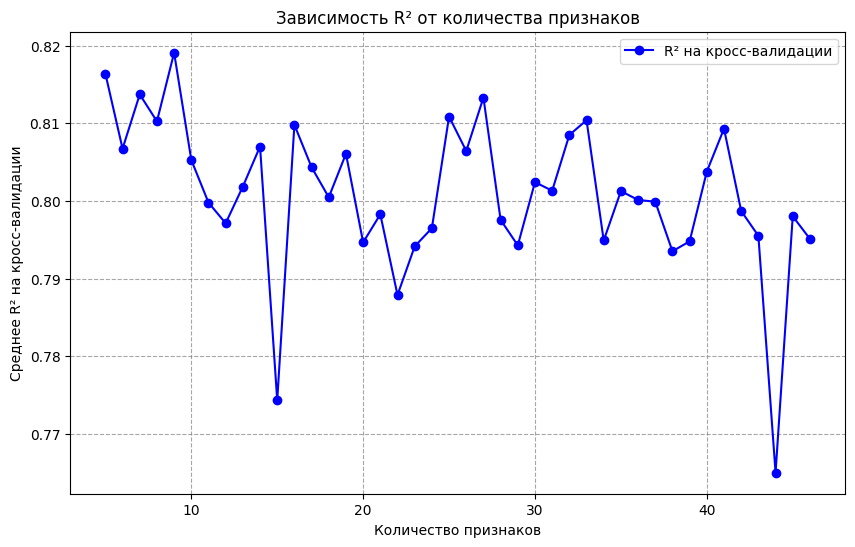

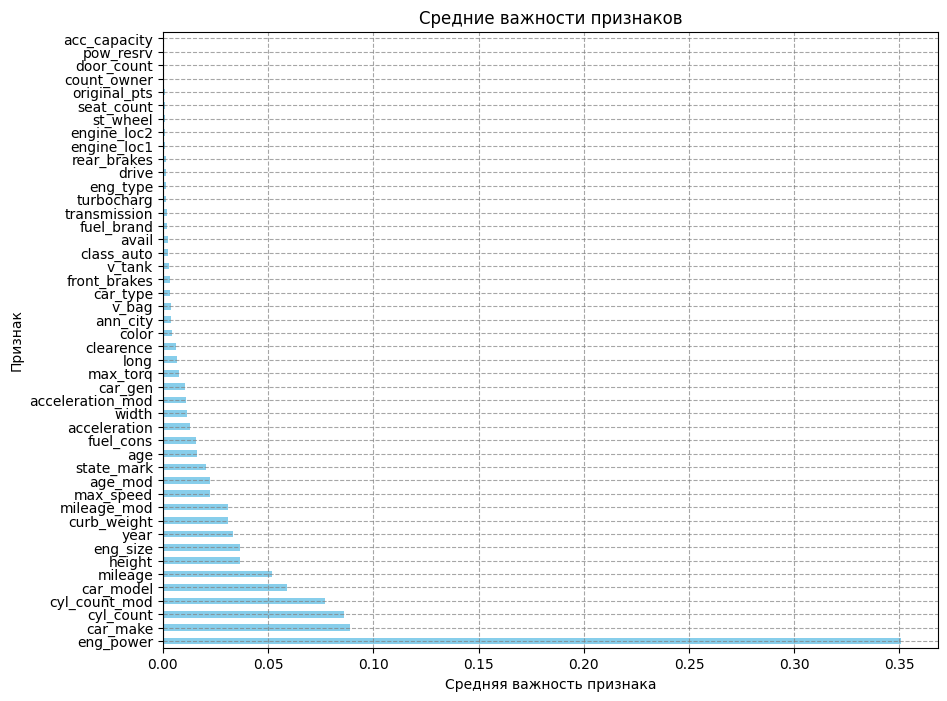

Таблица важностей признаков:
                        46        45  ...         5  mean_importance
car_make          0.088230  0.075933  ...  0.127900         0.089131
car_model         0.054606  0.065506  ...       NaN         0.058845
car_gen           0.008196  0.010044  ...       NaN         0.010570
car_type          0.002932  0.003583  ...       NaN         0.003421
ann_city          0.002896  0.003790  ...       NaN         0.003957
avail             0.001866  0.001941  ...       NaN         0.002267
color             0.003265  0.003141  ...       NaN         0.004118
eng_type          0.001349  0.001889  ...       NaN         0.001605
transmission      0.001345  0.002567  ...       NaN         0.001752
drive             0.001238  0.001592  ...       NaN         0.001311
st_wheel          0.001179  0.000394  ...       NaN         0.000887
original_pts      0.000934  0.001437  ...       NaN         0.000840
state_mark        0.006810  0.015911  ...       NaN         0.020312
class

In [38]:
# Параметры для TargetEncoder
smooth = 361  # Параметр сглаживания для TargetEncoder

# Инициализация модели для выбора признаков
model = RandomForestRegressor(n_jobs=-1)

# Максимальное количество признаков
max_features = X_train.shape[1]

# Списки для хранения результатов
results = {
    'num_features': [],  # Количество признаков
    'cv_r2': [],         # Среднее R² на кросс-валидации
    'selected_features': [],  # Список выбранных признаков
    'feature_importances': []  # Важности признаков
}

# Таблица для хранения важностей признаков
importance_table = pd.DataFrame(index=X_train.columns)

# Внешний цикл: перебор количества признаков
for num_of_features in tqdm(range(max_features, 4, -1), desc="Отбор признаков"):  # От максимального до 5
    if num_of_features == max_features:
        # На первом шаге используем все признаки
        selected_features = X_train.columns
    else:
        # Удаляем наименее важный признак на основе текущих важностей
        least_important_feature = importance_table.loc[selected_features, num_of_features + 1].idxmin()
        selected_features = selected_features.drop(least_important_feature)

    # Создание преобразователя признаков для выбранных признаков
    selected_cat_features = [col for col in cat_features if col in selected_features]
    col_transformer = make_column_transformer(
        (
            TargetEncoder(smooth=smooth),
            selected_cat_features
        ),
        remainder='passthrough',
        verbose_feature_names_out=True
    )

    # Создание пайплайна с обновлённым преобразователем
    pipeline = make_pipeline(
        col_transformer,  # Преобразование признаков
        model  # Модель RandomForestRegressor
    )

    # Обучение модели на выбранных признаках
    pipeline.fit(X_train[selected_features], y_train)

    # Кросс-валидация
    cv_scores = cross_val_score(
        pipeline,
        X_train[selected_features],
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    # Сохранение результатов
    results['num_features'].append(num_of_features)
    results['cv_r2'].append(cv_scores.mean())
    results['selected_features'].append(selected_features)

    # Получение важностей признаков
    importances = pipeline.steps[1][1].feature_importances_
    results['feature_importances'].append(importances)

    # Заполнение таблицы важностей
    for feature, importance in zip(selected_features, importances):
        importance_table.loc[feature, num_of_features] = importance

# Добавление столбца со средним значением важности
importance_table['mean_importance'] = importance_table.mean(axis=1)

# Построение графика зависимости R² от количества признаков
plt.figure(figsize=(10, 6))
plt.plot(results['num_features'], results['cv_r2'], marker='o', color='b', label='R² на кросс-валидации')
plt.xlabel('Количество признаков')
plt.ylabel('Среднее R² на кросс-валидации')
plt.title('Зависимость R² от количества признаков')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)  # Пунктирная сетка серого цвета
plt.legend()
plt.show()

# Построение столбчатой диаграммы средних важностей признаков
mean_importances = importance_table['mean_importance'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
mean_importances.plot(kind='barh', color='skyblue')
plt.xlabel('Средняя важность признака')
plt.ylabel('Признак')
plt.title('Средние важности признаков')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)  # Пунктирная сетка серого цвета
plt.show()

# Вывод таблицы важностей
print("Таблица важностей признаков:")
print(importance_table)

# Сохранение результатов в файл (опционально)
importance_table.to_csv(os.path.join(DATA_PATH, 'feature_importances_rfe.csv'))

In [14]:
importance_table = pd.read_csv(os.path.join(DATA_PATH, 'feature_importances_rfe.csv'),
                              index_col='Unnamed: 0')
importance_table

,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,mean_importance
car_make,0.088230,0.075933,0.078269,0.086950,0.085113,0.085412,0.089525,0.093864,0.085793,0.072673,0.082745,0.081529,0.089401,0.077118,0.075276,0.088381,0.103598,0.072790,0.079612,0.085291,0.084930,0.091526,0.070803,0.066162,0.081281,0.084959,0.079908,0.096447,0.084389,0.070848,0.075762,0.083657,0.093476,0.084613,0.100956,0.089175,0.118320,0.106164,0.127302,0.112506,0.134919,0.127900,0.089131
car_model,0.054606,0.065506,0.054487,0.057631,0.056398,0.048622,0.049984,0.066213,0.046715,0.049687,0.052297,0.047585,0.070730,0.047943,0.065041,0.050212,0.064127,0.051278,0.046590,0.050885,0.053938,0.049210,0.046952,0.052118,0.056258,0.048729,0.056784,0.057405,0.060983,0.061444,0.064108,0.064202,0.057414,0.063381,0.088999,0.067474,0.079607,0.067639,0.083710,0.076919,NaN,NaN,0.058845
car_gen,0.008196,0.010044,0.018386,0.004087,0.008509,0.022648,0.005278,0.005334,0.006724,0.012708,0.015862,0.005699,0.009490,0.019341,0.008992,0.025171,0.012401,0.006962,0.005096,0.005060,0.004947,0.007107,0.008069,0.009526,0.015823,0.016295,0.007633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010570
car_type,0.002932,0.003583,0.003749,0.001781,0.003432,0.003203,0.003167,0.003465,0.003853,0.002684,0.002498,0.002401,0.005463,0.007309,0.003187,0.002606,0.004027,0.002233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003421
ann_city,0.002896,0.003790,0.002706,0.003244,0.004509,0.003142,0.003422,0.003403,0.003058,0.003132,0.004013,0.005325,0.003670,0.003346,0.003287,0.003260,0.005220,0.004279,0.006191,0.004714,0.004512,0.004579,0.005307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003957
avail,0.001866,0.001941,0.003055,0.003127,0.002009,0.001956,0.002153,0.001922,0.002453,0.001755,0.002874,0.002111,0.001925,0.002605,0.002616,0.001896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002267
color,0.003265,0.003141,0.003711,0.003694,0.003659,0.002554,0.002183,0.003389,0.002577,0.004146,0.003202,0.005339,0.003627,0.004752,0.005087,0.003516,0.003601,0.007524,0.004402,0.006127,0.006927,0.004162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004118
eng_type,0.001349,0.001889,0.001096,0.000740,0.001862,0.001566,0.003826,0.001430,0.001083,0.001276,0.001557,0.001870,0.001989,0.000937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001605
transmission,0.001345,0.002567,0.002093,0.000872,0.002627,0.003233,0.000690,0.001131,0.001322,0.000913,0.001790,0.002068,0.001802,0.001835,0.001985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001752
drive,0.001238,0.001592,0.001168,0.000845,0.001374,0.001401,0.001800,0.001401,0.000887,0.001419,0.001293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001311


Видим, что достаточо 7-9 признаков, чтоб получить максимальное значение R2, а при количестве признаков более 10 качество в целом ухудшается с ростом количества признаков.

In [15]:
# Рассмотрим признаки, с которыми удалось достигнуть максимальное значение R2
importance_table[
    importance_table['9'].notnull()][['7', '9', 'mean_importance']
].sort_values(by='mean_importance', ascending=False)

,7,9,mean_importance
eng_power,0.378444,0.381422,0.350739
car_make,0.112506,0.106164,0.089131
cyl_count,0.092766,0.067574,0.085859
cyl_count_mod,0.110568,0.077603,0.077007
car_model,0.076919,0.067639,0.058845
mileage,0.131595,0.087007,0.052035
height,0.097201,0.090755,0.036859
eng_size,NaN,0.058064,0.036574
year,NaN,0.063772,0.033401


Видим, что признаки в топе по средней важности. Выберем топ-15 признаков по важности для дальнейшего отбора с помощью Sequential Feature Selection (SFS).

In [16]:
best_features = importance_table['mean_importance'].sort_values(
    ascending=False)[:15].index.to_list()
best_features

['eng_power',
 'car_make',
 'cyl_count',
 'cyl_count_mod',
 'car_model',
 'mileage',
 'height',
 'eng_size',
 'year',
 'curb_weight',
 'mileage_mod',
 'max_speed',
 'age_mod',
 'state_mark',
 'age']

In [ ]:
# Обновим список числовых признаков
num_features_best = (
    train[best_features].select_dtypes(
    exclude=['object', 'category']
    ).columns.to_list()
)
num_features_best

['eng_power',
 'cyl_count',
 'cyl_count_mod',
 'mileage',
 'height',
 'eng_size',
 'year',
 'curb_weight',
 'mileage_mod',
 'max_speed',
 'age_mod',
 'age']

In [ ]:
# Обновим список категориальных признаков
cat_features_best = train[best_features].select_dtypes(include=['category']).columns.to_list()
cat_features_best

['car_make', 'car_model', 'state_mark']

In [19]:
# Обновим таблицы с признаками
X_train_best = train[cat_features_best + num_features_best].copy()
X_test_best = test[cat_features_best + num_features_best].copy()

In [20]:
# Проверим размерность
X_train_best.shape, y_train.shape

((122898, 15), (122898,))

In [21]:
# Проверим размерность
X_test_best.shape, y_test.shape

((40966, 15), (40966,))

SequentialFeatureSelector (SFS) — это метод выбора признаков, который позволяет выполнять пошаговый отбор признаков (forward или backward) на основе качества модели. Этот метод является обёрточным (wrapper method), так как использует модель для оценки качества подмножества признаков. SFS позволяет учитывать взаимодействие между признаками, а использование кросс-валидации позволяет получить более надежную оценку. Будем использовать Backward Elimination:
- начинаем со всех признаков,
- на каждом шаге удаляем один признак, который меньше всего влияет на качество (R2) модели,
- процесс продолжается, пока не будет достигнуто заданное количество признаков, которое будем перебирать от максимального до 5.

In [14]:
# Пользовательский трансформер для динамического кодирования категориальных признаков
class DynamicTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smooth=10):
        self.smooth = smooth
        self.encoder = None
        self.cat_features = None
        self.feature_names = None

    def fit(self, X, y=None):
        # Преобразуем X в pandas.DataFrame, если это numpy.ndarray
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        
        # Определяем категориальные признаки
        self.cat_features = X.select_dtypes(include=['object', 'category']).columns
        if len(self.cat_features) > 0:
            self.encoder = TargetEncoder(smooth=self.smooth)
            self.encoder.fit(X[self.cat_features], y)
        return self

    def transform(self, X):
        # Преобразуем X в pandas.DataFrame, если это numpy.ndarray
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        
        if self.encoder is not None:
            X_encoded = X.copy()
            X_encoded[self.cat_features] = self.encoder.transform(X[self.cat_features])
            return X_encoded
        return X

In [ ]:
# Параметры для TargetEncoder
smooth = 361  # возьмём лучшее значение с кросс-валидации на всех признаках

# Максимальное количество признаков
max_features = X_train_best.shape[1]

# Списки для хранения результатов
results = {
    'num_features': [],  # Количество признаков
    'cv_r2': [],         # Среднее R² на кросс-валидации
    'selected_features': [],  # Список выбранных признаков
    'feature_importances': []  # Важности признаков
}

# Таблица для хранения важностей признаков
importance_table = pd.DataFrame(index=X_train_best.columns)

# Перебор количества признаков от максимального до 5
for num_of_features in tqdm(range(max_features, 4, -1), desc="Отбор признаков"):
    # Создание пайплайна с пользовательским трансформером
    pipeline = make_pipeline(
        DynamicTargetEncoder(smooth=smooth),  # Динамическое кодирование категориальных признаков
        RandomForestRegressor(n_jobs=5)  # Модель для оценки моделей
    )
    if num_of_features == max_features:
        # На первом шаге используем все признаки
        selected_features = X_train_best.columns
    else:
        # Инициализация SequentialFeatureSelector
        sfs = SequentialFeatureSelector(
            estimator=pipeline,
            n_features_to_select=num_of_features,
            direction='backward',
            scoring='r2',
            cv=5,
            n_jobs=5
        )

        # Применение SFS
        sfs.fit(X_train_best, y_train)

        # Получаем выбранные признаки
        selected_features = X_train_best.columns[sfs.get_support()]

    # Сохранение выбранных признаков
    results['selected_features'].append(selected_features)
    results['num_features'].append(num_of_features)

    # Кросс-валидация для проверки R2
    cv_scores = cross_val_score(
        pipeline,
        X_train_best[selected_features],
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=5
    )
    results['cv_r2'].append(cv_scores.mean())

    # Обучение модели на всех данных для получения важностей признаков
    pipeline.fit(X_train_best[selected_features], y_train)

    # Получение важностей признаков
    importances = pipeline.steps[1][1].feature_importances_
    results['feature_importances'].append(importances)

    # Заполнение таблицы важностей
    for feature, importance in zip(selected_features, importances):
        importance_table.loc[feature, num_of_features] = importance

# Добавление столбца со средним значением важности
importance_table['mean_importance'] = importance_table.mean(axis=1)

# Сохранение результатов в файлы
importance_table.to_csv(os.path.join(DATA_PATH, 'best_feature_importances_SFS.csv'))
pd.DataFrame(results).to_csv(os.path.join(DATA_PATH, 'best_feature_results_SFS.csv'))

Отбор признаков:  73%|███████▎  | 8/11 [6:17:16<3:10:30, 3810.23s/it]

Расчёты закончились корректно, но почему-то не отобразился весь прогресс-бар.

In [14]:
importance_table = pd.read_csv(os.path.join(DATA_PATH, 'best_feature_importances_SFS.csv'),
                              index_col='Unnamed: 0')
importance_table

,15,14,13,12,11,10,9,8,7,6,5,mean_importance
car_make,0.167803,0.221918,0.152934,0.240492,0.240997,0.236691,NaN,0.172098,0.266194,0.246297,0.363061,0.230849
car_model,0.078530,0.131823,0.093756,0.137634,0.142344,0.143046,0.121669,0.093023,0.146661,0.147101,NaN,0.123559
state_mark,0.013977,0.029329,0.016509,0.019302,0.029957,0.032039,0.072987,0.018570,0.046349,0.034172,0.042714,0.032355
eng_power,0.279618,NaN,0.264752,NaN,NaN,NaN,0.400073,0.333831,NaN,NaN,NaN,0.319568
cyl_count,0.090432,0.117529,0.098835,0.087674,0.093223,0.092099,0.168504,NaN,0.243358,NaN,0.280153,0.141312
cyl_count_mod,0.069072,0.119916,0.100197,0.133684,0.106258,0.125464,NaN,0.157584,NaN,0.296360,NaN,0.138567
mileage,0.056411,0.053754,NaN,NaN,NaN,NaN,0.098322,NaN,NaN,NaN,NaN,0.069496
height,0.051895,0.085847,0.056765,0.093398,0.094410,0.099272,0.060114,0.098544,0.096939,0.121247,0.121697,0.089103
eng_size,0.031513,0.061891,0.026231,0.069889,0.063896,0.064662,NaN,NaN,NaN,NaN,NaN,0.053014
year,0.026437,0.031989,0.053117,0.083558,0.105734,0.102605,0.034936,NaN,0.154136,0.154821,NaN,0.083037


In [15]:
results = pd.read_csv(os.path.join(DATA_PATH, 'best_feature_results_SFS.csv'),
                              index_col='Unnamed: 0')
results

,num_features,cv_r2,selected_features,feature_importances
0,15,0.818794,"Index(['car_make', 'car_model', 'state_mark', ...",[0.16780293 0.07853035 0.01397684 0.27961768 0...
1,14,0.804764,"Index(['car_make', 'car_model', 'state_mark', ...",[0.22191821 0.13182258 0.0293295 0.11752852 0...
2,13,0.803890,"Index(['car_make', 'car_model', 'state_mark', ...",[0.15293407 0.09375582 0.01650947 0.26475174 0...
3,12,0.804561,"Index(['car_make', 'car_model', 'state_mark', ...",[0.24049203 0.13763399 0.01930243 0.0876737 0...
4,11,0.806646,"Index(['car_make', 'car_model', 'state_mark', ...",[0.24099739 0.14234444 0.02995731 0.09322269 0...
5,10,0.804106,"Index(['car_make', 'car_model', 'state_mark', ...",[0.23669102 0.14304622 0.03203853 0.09209945 0...
6,9,0.825808,"Index(['car_model', 'state_mark', 'eng_power',...",[0.12166893 0.07298675 0.40007266 0.16850396 0...
7,8,0.823313,"Index(['car_make', 'car_model', 'state_mark', ...",[0.17209819 0.09302299 0.0185698 0.33383076 0...
8,7,0.802163,"Index(['car_make', 'car_model', 'state_mark', ...",[0.2661942 0.14666069 0.0463489 0.24335778 0...
9,6,0.798060,"Index(['car_make', 'car_model', 'state_mark', ...",[0.24629749 0.14710139 0.03417182 0.29636034 0...


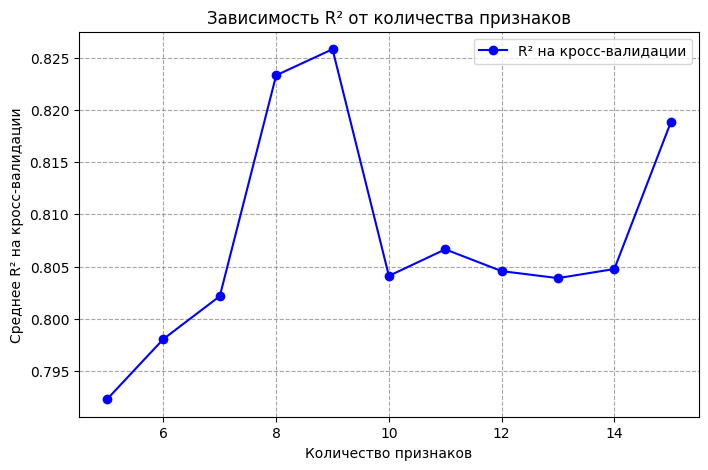

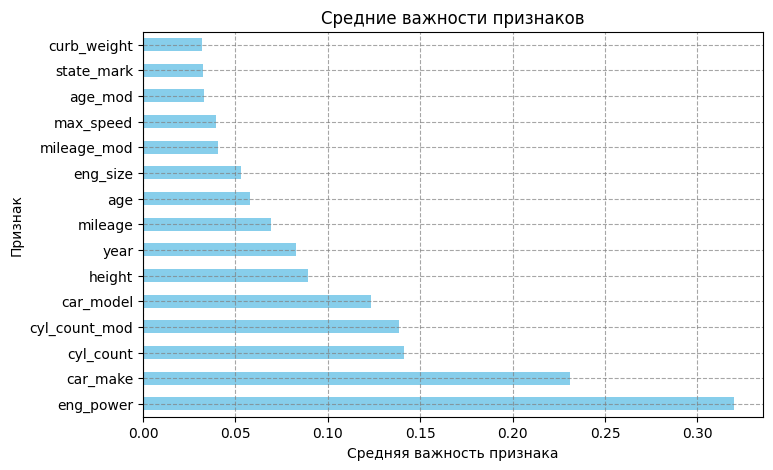

In [17]:
# Построение графика зависимости R² от количества признаков
plt.figure(figsize=(8, 5))
plt.plot(results['num_features'], results['cv_r2'], marker='o', color='b', label='R² на кросс-валидации')
plt.xlabel('Количество признаков')
plt.ylabel('Среднее R² на кросс-валидации')
plt.title('Зависимость R² от количества признаков')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.legend()
plt.show()

# Построение столбчатой диаграммы средних важностей признаков
mean_importances = importance_table['mean_importance'].sort_values(ascending=False)
plt.figure(figsize=(8, 5))
mean_importances.plot(kind='barh', color='skyblue')
plt.xlabel('Средняя важность признака')
plt.ylabel('Признак')
plt.title('Средние важности признаков')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.show()

Видим, что максимум качества достигается при 8-9 признаках.

In [21]:
# Рассмотрим признаки, с которыми удалось достигнуть максимальное значение R2
importance_table[
    importance_table['8'].notnull()|importance_table['9'].notnull()
][['8', '9', 'mean_importance']].sort_values(by='mean_importance', ascending=False)

,8,9,mean_importance
eng_power,0.333831,0.400073,0.319568
car_make,0.172098,NaN,0.230849
cyl_count,NaN,0.168504,0.141312
cyl_count_mod,0.157584,NaN,0.138567
car_model,0.093023,0.121669,0.123559
height,0.098544,0.060114,0.089103
year,NaN,0.034936,0.083037
mileage,NaN,0.098322,0.069496
age,0.068239,0.023337,0.057921
age_mod,0.058112,0.020058,0.033026


Выберем 9 признаков, отобранных с помощью Sequential Feature Selection (SFS).

In [16]:
best_features = importance_table[importance_table['9'].notnull()].index.to_list()
best_features

['car_model',
 'state_mark',
 'eng_power',
 'cyl_count',
 'mileage',
 'height',
 'year',
 'age_mod',
 'age']

In [17]:
# Обновим список числовых признаков
num_features_best = (
    train[best_features].select_dtypes(
    exclude=['object', 'category']
    ).columns.to_list()
)
num_features_best

['eng_power', 'cyl_count', 'mileage', 'height', 'year', 'age_mod', 'age']

In [18]:
# Обновим список категориальных признаков
cat_features_best = train[best_features].select_dtypes(include=['category']).columns.to_list()
cat_features_best

['car_model', 'state_mark']

In [19]:
# Обновим таблицы с признаками
X_train_best = train[cat_features_best + num_features_best].copy()
X_test_best = test[cat_features_best + num_features_best].copy()

In [20]:
# Проверим размерность
X_train_best.shape, y_train.shape

((122898, 9), (122898,))

In [21]:
# Проверим размерность
X_test_best.shape, y_test.shape

((40966, 9), (40966,))

Подберём гиперпараметры с выбранными признаками.

In [28]:
# Функция для подбора гиперпараметров
def objective_rf(trial):
    # Задаем диапазоны для гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 6, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 1000)
    max_features = trial.suggest_float('max_features', 0.3, 1.0)
    smooth = trial.suggest_float('smooth', 10, 1000)
    
    # Определим набор преобразований столбцов
    col_transformer = make_column_transformer(
        (
            TargetEncoder(smooth=smooth),
            cat_features_best
        ),
    
        remainder='passthrough',
        verbose_feature_names_out=True
    )

    # Создаем модель с текущими гиперпараметрами
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1
    )

    # Создаем пайплайн
    pipe = make_pipeline(col_transformer, model)

    # Вычисляем кросс-валидацию с кастомной метрикой
    scores = cross_val_score(
        pipe,
        X_train_best,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    # Возвращаем среднее значение метрики
    return scores.mean()

# Запускаем подбор гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=2000, n_jobs=1, gc_after_trial=True, show_progress_bar=True)

# Выводим лучшие параметры
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2025-03-15 14:14:14,362] A new study created in memory with name: no-name-5dd4ab78-39b5-4b4f-adb4-14811dd88371


  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2025-03-15 14:14:18,372] Trial 0 finished with value: 0.46002081712455667 and parameters: {'n_estimators': 172, 'max_depth': 8, 'min_samples_leaf': 671, 'max_features': 0.3580395582278351, 'smooth': 633.7559724452324}. Best is trial 0 with value: 0.46002081712455667.
[I 2025-03-15 14:14:20,585] Trial 1 finished with value: 0.4228612088106464 and parameters: {'n_estimators': 38, 'max_depth': 27, 'min_samples_leaf': 662, 'max_features': 0.9581433499197158, 'smooth': 233.2907536985035}. Best is trial 0 with value: 0.46002081712455667.
[I 2025-03-15 14:14:22,614] Trial 2 finished with value: 0.4183402517585118 and parameters: {'n_estimators': 42, 'max_depth': 8, 'min_samples_leaf': 944, 'max_features': 0.8189375447732494, 'smooth': 370.900836332105}. Best is trial 0 with value: 0.46002081712455667.
[I 2025-03-15 14:14:25,018] Trial 3 finished with value: 0.4774819385418881 and parameters: {'n_estimators': 105, 'max_depth': 16, 'min_samples_leaf': 530, 'max_features': 0.35299721189150035

In [34]:
# Лучшие параметры из optuna
best_params = study.best_params

# Создаем модель с лучшими параметрами
best_rf_feature_selected = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features']    
)
# Определим набор преобразований столбцов
col_transformer = make_column_transformer(
    (
        TargetEncoder(smooth=best_params['smooth']),
        cat_features_best
    ),
    remainder='passthrough',
    verbose_feature_names_out=True,
    force_int_remainder_cols=False
)

# Создаем пайплайн с лучшей моделью
pipe_best_rf_feature_selected = make_pipeline(col_transformer, best_rf_feature_selected)

# Обучаем пайплайн на всей обучающей выборке
pipe_best_rf_feature_selected.fit(X_train_best, y_train)

# Сохраним модель
try:
    _ = joblib.dump(pipe_best_rf_feature_selected,
                    os.path.join(MODEL_PATH, 'pipe_best_rf_feature_selected_sfs.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(pipe_best_rf_feature_selected,
                    'pipe_best_rf_feature_selected_sfs.pkl',
                    compress=0)

In [40]:
# Вычислим метрики
print_metrics(model=pipe_best_rf_feature_selected,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_best,
              X_test=X_test_best,
              log_y=False)

Обучающая выборка
R2                                        0.72081
MSE                                       8.5981
MAE                                       0.36253
Доля предсказаний 0,95-1,1 от цены        0.29262
Тестовая выборка
R2                                        0.76395
MSE                                       5.8288
MAE                                       0.3718
Доля предсказаний 0,95-1,1 от цены        0.28431


Метрика снизилась, но незначительно, а количество признаков сократилось с 46 до 9. Попробуем обучить пайплайн с параметрами случайного леса по умолчанию и параметром smooth из первоначального подбора гиперпараметров на всех признаках.

In [47]:
# Создание пайплайна 
col_transformer = make_column_transformer(
    (
        TargetEncoder(smooth=361),
        cat_features_best
    ),
    remainder='passthrough',
    verbose_feature_names_out=True,
    force_int_remainder_cols=False
)
pipe_rf_final= make_pipeline(
    col_transformer,
    RandomForestRegressor(n_jobs=-1)
)
# Кросс-валидация для проверки R2
cv_scores = cross_val_score(
    pipe_rf_final,
    X_train_best,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
cv_scores.mean()

0.8235039652254035

In [48]:
# Обучаем пайплайн на всей обучающей выборке
pipe_rf_final.fit(X_train_best, y_train)

# Сохраним модель
try:
    _ = joblib.dump(pipe_best_rf_feature_selected,
                    os.path.join(MODEL_PATH, 'pipe_rf_final.pkl'),
                    compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(pipe_best_rf_feature_selected,
                    'pipe_rf_final.pkl',
                    compress=0)

In [49]:
# Вычислим метрики
print_metrics(model=pipe_rf_final,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_best,
              X_test=X_test_best,
              log_y=False)

Обучающая выборка
R2                                        0.88334
MSE                                       3.5928
MAE                                       0.24719
Доля предсказаний 0,95-1,1 от цены        0.41447
Тестовая выборка
R2                                        0.91745
MSE                                       2.0384
MAE                                       0.33673
Доля предсказаний 0,95-1,1 от цены        0.3054


Удалось улучшить качество линейных моделей. Попробуем модель на основе градиентного бустинга.

### Catboost

Метрика R2 не доступна при испльзовании GPU, поэтому для выбора гиперпараметров используем метрику MAPE.

In [25]:
# Функция для подбора гиперпараметров CatBoost
def objective_cb(trial):
    # Зададим диапазоны для гиперпараметров
    params = {
        'iterations': trial.suggest_int('iterations', 300, 2000),
        'depth': trial.suggest_int('depth', 6, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
        'loss_function': 'RMSE',
        'eval_metric': 'R2',
        'task_type': 'CPU',
        'thread_count': 5
    }

    cv_results = cross_val_score(
        CatBoostRegressor(cat_features=cat_features_best, **params),
        X_train_best,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    # Вычисляем метрику
    # metric_value = cv_results['test-R2-mean'].min()
    
    # Возвращаем лучшее значение метрики
    return cv_results.mean()

# Запускаем подбор гиперпараметров
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective_cb, n_trials=500, n_jobs=1, gc_after_trial=True, show_progress_bar=True)

# Выводим лучшие параметры
print("Best parameters for CatBoost:", study_cb.best_params)
print("Best score:", study_cb.best_value)

[I 2025-03-15 20:34:22,348] A new study created in memory with name: no-name-fa114585-fae3-4e40-ab65-c084bebb3154


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-03-15 20:41:15,618] Trial 0 finished with value: 0.8177657481402463 and parameters: {'iterations': 1395, 'depth': 12, 'learning_rate': 0.283141284135374, 'min_data_in_leaf': 966}. Best is trial 0 with value: 0.8177657481402463.
[I 2025-03-15 20:44:28,186] Trial 1 finished with value: 0.8318421230114137 and parameters: {'iterations': 1846, 'depth': 10, 'learning_rate': 0.10741948810452992, 'min_data_in_leaf': 889}. Best is trial 1 with value: 0.8318421230114137.
[I 2025-03-15 20:51:17,964] Trial 2 finished with value: 0.8269156916931735 and parameters: {'iterations': 1519, 'depth': 12, 'learning_rate': 0.031091889754619823, 'min_data_in_leaf': 171}. Best is trial 1 with value: 0.8318421230114137.
[I 2025-03-15 21:25:25,468] Trial 3 finished with value: 0.8240639249896681 and parameters: {'iterations': 1810, 'depth': 14, 'learning_rate': 0.060558178001007754, 'min_data_in_leaf': 512}. Best is trial 1 with value: 0.8318421230114137.
[I 2025-03-15 21:31:06,194] Trial 4 finished wit

D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
   

[W 2025-03-16 15:21:28,142] Trial 450 failed with parameters: {'iterations': 1327, 'depth': 16, 'learning_rate': 0.14227724423754776, 'min_data_in_leaf': 481} because of the following error: The value nan is not acceptable.
[W 2025-03-16 15:21:28,144] Trial 450 failed with value nan.
[I 2025-03-16 15:22:16,190] Trial 451 finished with value: 0.8566669642223687 and parameters: {'iterations': 918, 'depth': 6, 'learning_rate': 0.14933740746092442, 'min_data_in_leaf': 487}. Best is trial 372 with value: 0.864890625779975.
[I 2025-03-16 15:23:07,681] Trial 452 finished with value: 0.8476135591649845 and parameters: {'iterations': 1018, 'depth': 6, 'learning_rate': 0.1977765157361267, 'min_data_in_leaf': 352}. Best is trial 372 with value: 0.864890625779975.
[I 2025-03-16 15:24:12,492] Trial 453 finished with value: 0.849171879003646 and parameters: {'iterations': 1314, 'depth': 6, 'learning_rate': 0.13446071476555196, 'min_data_in_leaf': 459}. Best is trial 372 with value: 0.864890625779975

D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
   

[W 2025-03-16 17:28:32,233] Trial 462 failed with parameters: {'iterations': 1378, 'depth': 16, 'learning_rate': 0.22407063540815447, 'min_data_in_leaf': 513} because of the following error: The value nan is not acceptable.
[W 2025-03-16 17:28:32,235] Trial 462 failed with value nan.
[I 2025-03-16 17:30:08,984] Trial 463 finished with value: 0.8526804249077395 and parameters: {'iterations': 1804, 'depth': 6, 'learning_rate': 0.2977819625933158, 'min_data_in_leaf': 527}. Best is trial 372 with value: 0.864890625779975.
[I 2025-03-16 17:31:19,021] Trial 464 finished with value: 0.8541210497259586 and parameters: {'iterations': 1377, 'depth': 6, 'learning_rate': 0.23134694876788636, 'min_data_in_leaf': 235}. Best is trial 372 with value: 0.864890625779975.
[I 2025-03-16 17:32:04,163] Trial 465 finished with value: 0.8446953934559327 and parameters: {'iterations': 837, 'depth': 6, 'learning_rate': 0.36662595158850164, 'min_data_in_leaf': 427}. Best is trial 372 with value: 0.86489062577997

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 2410, in _fit
    self._train(
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 1790, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 5017, in _catboost._CatBoost._train
  File "_catboost.pyx", line 5066, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 2448, in _fit
    self.get_feature_importance(type=EFstrType.PredictionValuesChange)
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 3249, in get_feature_importance
    fstr, feature_names = self._calc_fstr(type, data, reference_data, thread_count, verbose, model_output, shap_mode, interaction_indices,
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\YandexDisk-Dmitry\HSE\valuation_of_used_cars\venv\Lib\site-packages\catboost\core.py", line 1875, in _calc_fstr
    return self._object._calc_fstr(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "_catboost.pyx", line 5255, in _catboost._CatBoost._calc_fstr
  File "_catboost.pyx", line 5320, in _catboost._CatBoost._calc_fstr
_catboost.CatBoostError: bad allocation


In [28]:
# Обучим модель с лучшими параметрами на всей обучающей выборке
train_pool = Pool(
    data=X_train_best,
    label=y_train,
    cat_features=cat_features_best,
    thread_count=5,
    feature_names=X_train_best.columns.tolist()
)
best_cb = CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='R2',
        task_type='CPU',
        thread_count=5,
        **study_cb.best_params)
best_cb.fit(train_pool)
# Сохраним модель
try:
    _ = joblib.dump(best_cb, os.path.join(MODEL_PATH, 'best_cb.pkl'), compress=0)
except:
    print('Changed directory for model to current directory')
    _ = joblib.dump(best_cb, 'best_cb.pkl', compress=0)

0:	learn: 0.2549704	total: 201ms	remaining: 3m 4s
1:	learn: 0.4307248	total: 247ms	remaining: 1m 53s
2:	learn: 0.5521102	total: 298ms	remaining: 1m 30s
3:	learn: 0.6277784	total: 372ms	remaining: 1m 24s
4:	learn: 0.6830831	total: 457ms	remaining: 1m 23s
5:	learn: 0.7217490	total: 506ms	remaining: 1m 16s
6:	learn: 0.7481660	total: 551ms	remaining: 1m 11s
7:	learn: 0.7673791	total: 595ms	remaining: 1m 7s
8:	learn: 0.7847517	total: 638ms	remaining: 1m 4s
9:	learn: 0.7982588	total: 680ms	remaining: 1m 1s
10:	learn: 0.8107878	total: 724ms	remaining: 59.7s
11:	learn: 0.8222906	total: 764ms	remaining: 57.7s
12:	learn: 0.8306844	total: 802ms	remaining: 55.8s
13:	learn: 0.8337539	total: 845ms	remaining: 54.5s
14:	learn: 0.8400512	total: 889ms	remaining: 53.5s
15:	learn: 0.8426067	total: 932ms	remaining: 52.5s
16:	learn: 0.8479108	total: 978ms	remaining: 51.8s
17:	learn: 0.8505000	total: 1.02s	remaining: 51.2s
18:	learn: 0.8534324	total: 1.06s	remaining: 50.4s
19:	learn: 0.8548864	total: 1.1s	re

In [29]:
# Вычислим метрики
print_metrics(model=best_cb,
              y_train=y_train,
              y_test=y_test,
              X_train=X_train_best,
              X_test=X_test_best,
              log_y=False)

Обучающая выборка
R2                                        0.92627
MSE                                       2.2706
MAE                                       0.29372
Доля предсказаний 0,95-1,1 от цены        0.30066
Тестовая выборка
R2                                        0.89904
MSE                                       2.4931
MAE                                       0.32809
Доля предсказаний 0,95-1,1 от цены        0.29412


По результатам отбора признаков наиболее важными с точки зрения важности и качества предсказаний являются:  
['car_model', 'state_mark', 'eng_power', 'cyl_count', 'mileage', 'height', 'year', 'age_mod', 'age'].  

В ходе экспериментов с моделями и подбора гиперпараметров наилучший результат на кросс-валидации достигнут моделью CatBoostRegressor c параметрами:  
{'loss_function': 'RMSE',
 'eval_metric': 'R2',
 'task_type': 'CPU',
 'thread_count': 5,
 'iterations': 918,
 'depth': 6,
 'learning_rate': 0.24685623135762386,
 'min_data_in_leaf': 456}.